In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler
from datetime import datetime

#Ruta al directorio base y del archivo Silver
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..", ".."))
SILVER_DIR = os.path.join(BASE_DIR, "data", "silver")
SILVER_FILE_PATH = os.path.join(SILVER_DIR, "silver_data.parquet")

# Cargar el dataset Silver
try:
    df_gold = pd.read_parquet(SILVER_FILE_PATH)
    print(f"Dimensiones del DataFrame: {df_gold.shape}")
    print(display(df_gold.head()))
    print("\nInformación del DataFrame:")
    df_gold.info()
except Exception as e:
    print(f"Ocurrió un error al cargar los datos Silver: {e}")


Dimensiones del DataFrame: (28128, 8)


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position
timestamp,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11


None

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28128 entries, 2024-09-10 04:00:00 to 2025-06-30 03:45:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   voltaje                     28128 non-null  float64
 1   corriente_carga             28128 non-null  float64
 2   temperatura_aceite          28128 non-null  float64
 3   temperatura_ambiente        28128 non-null  float64
 4   temperatura_punto_caliente  28128 non-null  float64
 5   temperatura_burbujeo        28128 non-null  float64
 6   potencia_aparente           28128 non-null  float64
 7   tap_position                28128 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


# Ingeniera de Caracteristicas


In [19]:
df_gold['hour_of_day'] = df_gold.index.hour
df_gold['day_of_week'] = df_gold.index.dayofweek # Lunes=0, Domingo=6
df_gold['month_of_year'] = df_gold.index.month
df_gold['day_of_year'] = df_gold.index.dayofyear
df_gold['week_of_year'] = df_gold.index.isocalendar().week.astype(int) # Necesita ser int para algunos modelos
df_gold['is_weekend'] = (df_gold.index.dayofweek >= 5).astype(int) # 1 si es fin de semana, 0 si no
df_gold['quarter_of_year'] = df_gold.index.quarter # Trimestre del año
#ver las características temporales
print("\nPrimeras 5 filas del DataFrame Gold con características temporales:")
print(display(df_gold.tail()))



Primeras 5 filas del DataFrame Gold con características temporales:


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year
timestamp,,,,,,,,,,,,,,,
2025-06-30 02:45:00,131.862888,688.338204,37.858095,16.530000,35.417641,153.104431,27.802991,8,2,0,6,181,27,0,2
2025-06-30 03:00:00,131.985069,678.283737,45.850101,20.785572,50.010959,153.163773,27.375312,8,3,0,6,181,27,0,2
2025-06-30 03:15:00,132.150829,668.648083,42.555333,19.068333,50.044694,153.223114,26.947633,8,3,0,6,181,27,0,2
2025-06-30 03:30:00,132.251691,661.406774,41.368667,19.553333,49.382498,153.282455,26.722704,8,3,0,6,181,27,0,2
2025-06-30 03:45:00,132.456340,654.233668,44.477143,21.920000,49.417194,169.409826,26.494724,8,3,0,6,181,27,0,2


None


2.2 Características Diferenciales y de Relación

In [20]:
# Diferencial Temperatura Aceite-Ambiente
df_gold['temp_aceite_diff_ambiente'] = df_gold['temperatura_aceite'] - df_gold['temperatura_ambiente']
# Diferencial Punto Caliente-Aceite
#df_gold['temp_punto_caliente_diff_aceite'] = df_gold['temperatura_punto_caliente'] - df_gold['temperatura_aceite']
df_gold.head()

,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente
timestamp,,,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,4,1,9,254,37,0,3,24.400000
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3,26.850000
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3,26.542857
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3,26.585714
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3,26.795238


Tasa de cambio (Ej: promedio de la última hora para temperaturas)
Se usa .diff() para la diferencia y luego .rolling().mean() para suavizar el ruido en la tasa de cambio
Puedes ajustar la ventana de '1H' (1 hora) según lo que consideres relevante

In [21]:

print("Calculando tasas de cambio...")
df_gold['delta_temp_aceite_1h'] = df_gold['temperatura_aceite'].diff().rolling(window='1H').mean()
df_gold['delta_potencia_aparente_1h'] = df_gold['potencia_aparente'].diff().rolling(window='1H').mean()
df_gold['delta_voltaje_1h'] = df_gold['voltaje'].diff().rolling(window='1H').mean()
df_gold.head(10)


Calculando tasas de cambio...


C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_4332\2539598571.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_gold['delta_temp_aceite_1h'] = df_gold['temperatura_aceite'].diff().rolling(window='1H').mean()
C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_4332\2539598571.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_gold['delta_potencia_aparente_1h'] = df_gold['potencia_aparente'].diff().rolling(window='1H').mean()
C:\Users\Asus TUF\AppData\Local\Temp\ipykernel_4332\2539598571.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_gold['delta_voltaje_1h'] = df_gold['voltaje'].diff().rolling(window='1H').mean()


,voltaje,corriente_carga,temperatura_aceite,temperatura_ambiente,temperatura_punto_caliente,temperatura_burbujeo,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,,,,
2024-09-10 04:00:00,131.041825,739.327177,50.900000,26.500000,54.653733,178.928398,30.745757,10,4,1,9,254,37,0,3,24.400000,NaN,NaN,NaN
2024-09-10 04:15:00,130.693073,728.593612,53.500000,26.650000,58.642727,178.854984,30.232734,11,4,1,9,254,37,0,3,26.850000,2.600000,-0.513023,-0.348752
2024-09-10 04:30:00,130.812457,715.310359,53.342857,26.800000,58.308074,178.781570,29.725678,11,4,1,9,254,37,0,3,26.542857,1.221428,-0.510039,-0.114684
2024-09-10 04:45:00,130.924854,701.814300,53.185714,26.600000,57.973421,178.411140,29.164683,11,4,1,9,254,37,0,3,26.585714,0.761905,-0.527025,-0.038990
2024-09-10 05:00:00,130.564417,688.681148,53.028571,26.233334,57.638768,176.250397,28.610652,11,5,1,9,254,37,0,3,26.795238,0.532143,-0.533776,-0.119352
2024-09-10 05:15:00,130.947408,679.651644,52.871428,25.866667,57.304115,176.126086,28.242603,11,5,1,9,254,37,0,3,27.004762,-0.157143,-0.497533,0.063584
2024-09-10 05:30:00,131.011387,671.082906,52.714285,25.500000,57.232162,176.001775,27.921659,10,5,1,9,254,37,0,3,27.214285,-0.157143,-0.451005,0.049733
2024-09-10 05:45:00,131.140706,663.630621,52.557143,26.299999,56.913330,175.877464,27.625818,11,5,1,9,254,37,0,3,26.257143,-0.157143,-0.384716,0.053963
2024-09-10 06:00:00,131.046645,656.529251,52.400000,26.500000,56.749290,175.753153,27.324530,11,6,1,9,254,37,0,3,25.900000,-0.157143,-0.321531,0.120557


In [22]:
for col in df_gold.columns:
    print(f"Procesando columna: {df_gold[col].isnull().sum()} valores nulos")

Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 0 valores nulos
Procesando columna: 1 valores nulos
Procesando columna: 1 valores nulos
Procesando columna: 1 valores nulos


 Algunas de estas nuevas columnas tendrán NaNs al principio debido a .diff() y .rolling().

In [23]:

df_gold.dropna(inplace=True) # ¡Precaución! Evalúa si 0 es un valor sensato para los NaNs iniciales.

2.3 Manejo de Multicolinealidad (Selección de Características)
Según el heatmap:
- 'corriente_carga' y 'potencia_aparente' (0.99): Se escogera potencia aparente debido a que esta abarca tambien la corriente en su formula
- 'temperatura_aceite', 'temperatura_punto_caliente', 'temperatura_burbujeo' (todas >0.98): Se elige 'temperatura_punto_caliente' como la más crítica y, opcionalmente, una más si es muy relevante.

In [24]:
df_copy= df_gold.copy()  # Copia del DataFrame original para evitar problemas de referencia
# Lista de columnas a eliminar debido a alta multicolinealidad o redundancia en los datos
cols_to_drop_for_multicollinearity = [
    'corriente_carga',  # Alta correlación con corriente_carga
    'temperatura_aceite',
    'temperatura_burbujeo'
]

# Asegurarse de que las columnas existan antes de intentar eliminarlas
existing_cols_to_drop = [col for col in cols_to_drop_for_multicollinearity if col in df_copy.columns]

if existing_cols_to_drop:
    df_copy = df_copy.drop(columns=existing_cols_to_drop)
    print(f"Columnas eliminadas por multicolinealidad: {existing_cols_to_drop}")
else:
    print("No se encontraron columnas para eliminar por multicolinealidad o ya fueron eliminadas.")

print(f"Dimensiones del DataFrame después de Feature Engineering: {df_copy.shape}")
print(df_copy.head())

Columnas eliminadas por multicolinealidad: ['corriente_carga', 'temperatura_aceite', 'temperatura_burbujeo']
Dimensiones del DataFrame después de Feature Engineering: (28127, 16)
                        voltaje  temperatura_ambiente  \
timestamp                                               
2024-09-10 04:15:00  130.693073             26.650000   
2024-09-10 04:30:00  130.812457             26.800000   
2024-09-10 04:45:00  130.924854             26.600000   
2024-09-10 05:00:00  130.564417             26.233334   
2024-09-10 05:15:00  130.947408             25.866667   

                     temperatura_punto_caliente  potencia_aparente  \
timestamp                                                            
2024-09-10 04:15:00                   58.642727          30.232734   
2024-09-10 04:30:00                   58.308074          29.725678   
2024-09-10 04:45:00                   57.973421          29.164683   
2024-09-10 05:00:00                   57.638768          28.610652   
2

Escalado de caracteristicas
Se define las columnas que no se van a escalar, tap position y las variables de tiempo

In [25]:
# Definir las columnas que no se van a escalar
# Estas son las columnas de tiempo y 'tap_position' que no deben ser escaladas
excluded_cols_from_scaling = [
    'tap position','hour_of_day', 'day_of_week', 'month_of_year', 'day_of_year',
    'week_of_year', 'is_weekend', 'quarter_of_year', 
]

# Columnas a escalar: todas las numéricas que no estén en la lista de exclusión
# y que no sean el índice
cols_to_scale = [col for col in df_copy.select_dtypes(include=np.number).columns if col not in excluded_cols_from_scaling]
print(f"Columnas a escalar: {cols_to_scale}")

if not cols_to_scale:
    print("No se encontraron columnas numéricas para escalar. Revisa la lista de exclusión o tipos de datos.")
else:
    scaler = RobustScaler()
    print(f"Escalando las siguientes columnas con RobustScaler: {cols_to_scale}")
    df_copy[cols_to_scale] = scaler.fit_transform(df_copy[cols_to_scale])
    print("Características escaladas con RobustScaler.")

print("\nPrimeras 5 filas del DataFrame_copy después de escalado:")
print(display(df_copy.head()))
print(f"Dimensiones finales del DataFrame_copy: {df_copy.shape}")

Columnas a escalar: ['voltaje', 'temperatura_ambiente', 'temperatura_punto_caliente', 'potencia_aparente', 'tap_position', 'temp_aceite_diff_ambiente', 'delta_temp_aceite_1h', 'delta_potencia_aparente_1h', 'delta_voltaje_1h']
Escalando las siguientes columnas con RobustScaler: ['voltaje', 'temperatura_ambiente', 'temperatura_punto_caliente', 'potencia_aparente', 'tap_position', 'temp_aceite_diff_ambiente', 'delta_temp_aceite_1h', 'delta_potencia_aparente_1h', 'delta_voltaje_1h']
Características escaladas con RobustScaler.

Primeras 5 filas del DataFrame_copy después de escalado:


,voltaje,temperatura_ambiente,temperatura_punto_caliente,potencia_aparente,tap_position,hour_of_day,day_of_week,month_of_year,day_of_year,week_of_year,is_weekend,quarter_of_year,temp_aceite_diff_ambiente,delta_temp_aceite_1h,delta_potencia_aparente_1h,delta_voltaje_1h
timestamp,,,,,,,,,,,,,,,,
2024-09-10 04:15:00,0.117813,0.142586,0.496258,0.147686,1.0,4,1,9,254,37,0,3,0.996268,9.905655,-0.920110,-1.013909
2024-09-10 04:30:00,0.155407,0.159696,0.470274,0.095460,1.0,4,1,9,254,37,0,3,0.927505,4.703502,-0.914636,-0.353782
2024-09-10 04:45:00,0.190801,0.136882,0.444289,0.037678,1.0,4,1,9,254,37,0,3,0.937100,2.969451,-0.945804,-0.140308
2024-09-10 05:00:00,0.077300,0.095057,0.418305,-0.019387,1.0,5,1,9,254,37,0,3,0.984008,2.102425,-0.958192,-0.366947
2024-09-10 05:15:00,0.197903,0.053232,0.392320,-0.057295,1.0,5,1,9,254,37,0,3,1.030916,-0.498651,-0.891687,0.148976


None
Dimensiones finales del DataFrame_copy: (28127, 16)


Division de datos (Entrenamiento, Validacion y Prueba)

In [26]:
import math
a= math.sqrt(3)
print(f"Raíz cuadrada de 3: {a}")

Raíz cuadrada de 3: 1.7320508075688772


In [27]:
# Definir los porcentajes (puedes ajustarlos)
train_ratio = 0.8
val_ratio = 0.15 # Validación
test_ratio = 0.05 # Prueba  

# Asegurarse de que los ratios sumen 1 o menos
if (train_ratio + val_ratio + test_ratio) > 1.0:
    print("Advertencia: La suma de los ratios es mayor a 1. Ajustando test_ratio.")
    test_ratio = 1.0 - train_ratio - val_ratio
    if test_ratio < 0: test_ratio = 0 # Asegurarse que no sea negativo

total_rows = df_copy.shape[0]
train_split = int(total_rows * train_ratio)
val_split = int(total_rows * (train_ratio + val_ratio))

# Dividir el DataFrame
df_train = df_copy.iloc[:train_split]
df_val = df_copy.iloc[train_split:val_split]
df_test = df_copy.iloc[val_split:]

print(f"Total de registros: {total_rows}")
print(f"Conjunto de Entrenamiento: {len(df_train)} registros ({(len(df_train)/total_rows)*100:.2f}%)")
print(f"Conjunto de Validación: {len(df_val)} registros ({(len(df_val)/total_rows)*100:.2f}%)")
print(f"Conjunto de Prueba: {len(df_test)} registros ({(len(df_test)/total_rows)*100:.2f}%)")

print("\nFechas de los conjuntos:")
print(f"  Entrenamiento: {df_train.index.min()} a {df_train.index.max()}")
print(f"  Validación:    {df_val.index.min()} a {df_val.index.max()}")
print(f"  Prueba:        {df_test.index.min()} a {df_test.index.max()}")

# Opcional: Guardar los datasets resultantes
# Asegúrate de crear una carpeta para los datos Gold si aún no existe
GOLD_DIR = os.path.join(BASE_DIR, "data", "gold")
os.makedirs(GOLD_DIR, exist_ok=True)

df_train.to_parquet(os.path.join(GOLD_DIR, "train_data.parquet"), index=True)
df_val.to_parquet(os.path.join(GOLD_DIR, "val_data.parquet"), index=True)
df_test.to_parquet(os.path.join(GOLD_DIR, "test_data.parquet"), index=True)

print(f"\nDatasets Gold guardados en: {GOLD_DIR}")

Total de registros: 28127
Conjunto de Entrenamiento: 22501 registros (80.00%)
Conjunto de Validación: 4219 registros (15.00%)
Conjunto de Prueba: 1407 registros (5.00%)

Fechas de los conjuntos:
  Entrenamiento: 2024-09-10 04:15:00 a 2025-05-02 13:15:00
  Validación:    2025-05-02 13:30:00 a 2025-06-15 12:00:00
  Prueba:        2025-06-15 12:15:00 a 2025-06-30 03:45:00

Datasets Gold guardados en: c:\Users\Asus TUF\Desktop\proy_ml\data\gold


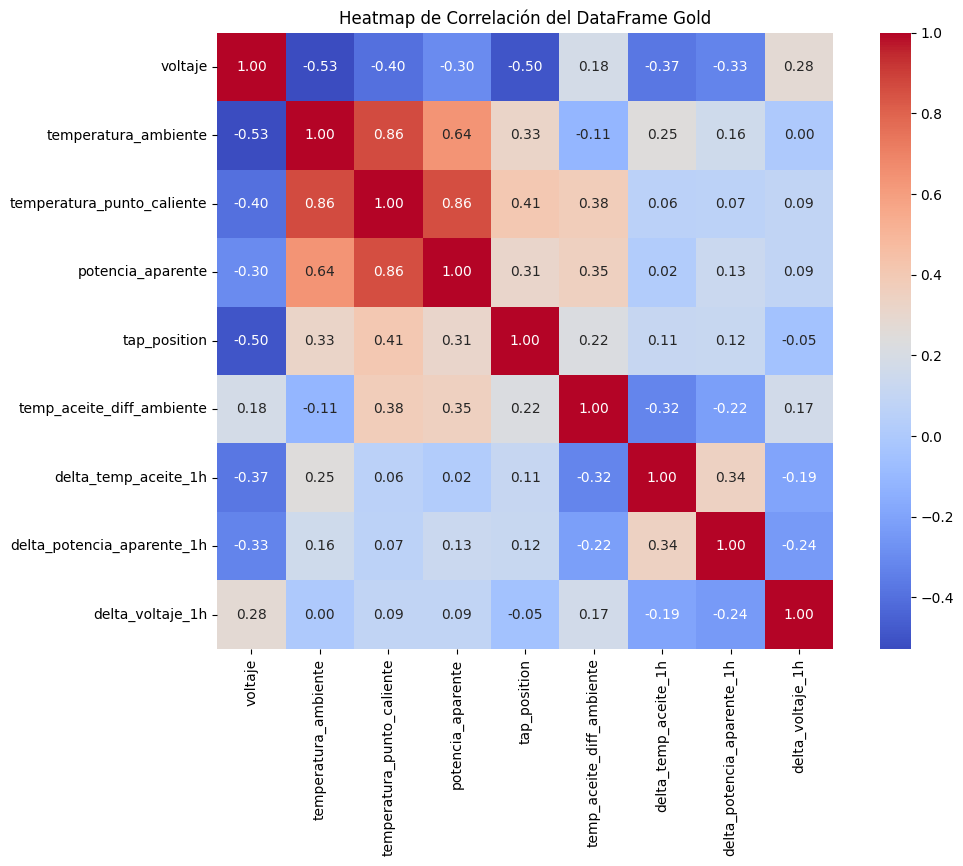

In [28]:
#funcion para graficar el heatmap de correlación
def plot_correlation_heatmap(df, title="Heatmap de Correlación"):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(title)
    plt.show()
plot_correlation_heatmap(df_copy[cols_to_scale], title="Heatmap de Correlación del DataFrame Gold")


In [29]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Recargar los datos Gold (si no continuas del notebook anterior) ---
# Si continuas del mismo notebook, puedes saltar esta parte
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..",".."))
GOLD_DIR = os.path.join(BASE_DIR, "data", "gold")

try:
    df_train = pd.read_parquet(os.path.join(GOLD_DIR, "train_data.parquet"))
    df_val = pd.read_parquet(os.path.join(GOLD_DIR, "val_data.parquet"))
    df_test = pd.read_parquet(os.path.join(GOLD_DIR, "test_data.parquet"))
    print("Datasets Gold (Train, Val, Test) cargados correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontraron los archivos Parquet en {GOLD_DIR}")
    print("Asegúrate de haber guardado los datasets de la capa Gold en el paso anterior.")
    # Si no se encuentran, puedes salir o manejar el error.
    exit()

Datasets Gold (Train, Val, Test) cargados correctamente.


In [30]:
# Definir la variable objetivo
TARGET_VARIABLE = 'temperatura_punto_caliente'

# Lista de todas las columnas, excluimos las que serán target o causan data leakage.
features_to_exclude = [TARGET_VARIABLE]
features = [col for col in df_train.columns if col not in features_to_exclude]

# pero es bueno verificar que las columnas esperadas estén ahí.
missing_excluded_features = [f for f in features_to_exclude if f not in df_train.columns]
if missing_excluded_features:
    print(f"caracteristicas a excluir no se encontraron en el DataFrame: {missing_excluded_features}")

# Crear los conjuntos X e Y
X_train = df_train[features]
Y_train = df_train[TARGET_VARIABLE]

X_val = df_val[features]
Y_val = df_val[TARGET_VARIABLE]

X_test = df_test[features]
Y_test = df_test[TARGET_VARIABLE]

print(f"\nConjuntos X e Y creados para Entrenamiento, Validación y Prueba.")
print(f"Número de características (X): {len(features)}")
print(f"Ejemplo de características: {features[:5]}...") # Muestra las primeras 5 características
print(f"Variable Objetivo (Y): {TARGET_VARIABLE}")

print(f"\nDimensiones de los conjuntos:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val:   {X_val.shape}, Y_val:   {Y_val.shape}")
print(f"X_test:  {X_test.shape}, Y_test:  {Y_test.shape}")


Conjuntos X e Y creados para Entrenamiento, Validación y Prueba.
Número de características (X): 15
Ejemplo de características: ['voltaje', 'temperatura_ambiente', 'potencia_aparente', 'tap_position', 'hour_of_day']...
Variable Objetivo (Y): temperatura_punto_caliente

Dimensiones de los conjuntos:
X_train: (22501, 15), Y_train: (22501,)
X_val:   (4219, 15), Y_val:   (4219,)
X_test:  (1407, 15), Y_test:  (1407,)


 Selección y Entrenamiento de Modelos

In [31]:
# 1. Modelo Random Forest Regressor
print("\nEntrenando Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 usa todos los núcleos
rf_model.fit(X_train, Y_train)
print("Random Forest Regressor entrenado.")

# 2. Modelo XGBoost Regressor
print("\nEntrenando XGBoost Regressor...")
# XGBoost es muy potente y rápido
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, Y_train)
print("XGBoost Regressor entrenado.")


Entrenando Random Forest Regressor...
Random Forest Regressor entrenado.

Entrenando XGBoost Regressor...
XGBoost Regressor entrenado.


Evaluación de Modelos

In [32]:

def evaluate_model(model, X, Y, name="Modelo"):
    """
    Evalúa el modelo y imprime métricas de regresión.
    """
    predictions = model.predict(X)

    mae = mean_absolute_error(Y, predictions)
    rmse = np.sqrt(mean_squared_error(Y, predictions))
    r2 = r2_score(Y, predictions)

    print(f"\nResultados de {name}:")
    print(f"  MAE (Mean Absolute Error): {mae:.3f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.3f}")
    print(f"  R2 (Coefficient of Determination): {r2:.3f}")
    return predictions

# --- Evaluación en el conjunto de VALIDACIÓN ---
print("\nEvaluando en el conjunto de VALIDACIÓN:")
rf_val_predictions = evaluate_model(rf_model, X_val, Y_val, "Random Forest (Validación)")
xgb_val_predictions = evaluate_model(xgb_model, X_val, Y_val, "XGBoost (Validación)")

# --- Opcional: Evaluación en el conjunto de ENTRENAMIENTO (para verificar overfitting) ---
# Esto es solo para diagnóstico. Si las métricas en entrenamiento son mucho mejores que en validación, hay overfitting.
print("\nEvaluando en el conjunto de ENTRENAMIENTO (solo para diagnóstico de overfitting):")
evaluate_model(rf_model, X_train, Y_train, "Random Forest (Entrenamiento)")
evaluate_model(xgb_model, X_train, Y_train, "XGBoost (Entrenamiento)")


Evaluando en el conjunto de VALIDACIÓN:

Resultados de Random Forest (Validación):
  MAE (Mean Absolute Error): 0.048
  RMSE (Root Mean Squared Error): 0.109
  R2 (Coefficient of Determination): 0.927

Resultados de XGBoost (Validación):
  MAE (Mean Absolute Error): 0.057
  RMSE (Root Mean Squared Error): 0.122
  R2 (Coefficient of Determination): 0.909

Evaluando en el conjunto de ENTRENAMIENTO (solo para diagnóstico de overfitting):

Resultados de Random Forest (Entrenamiento):
  MAE (Mean Absolute Error): 0.006
  RMSE (Root Mean Squared Error): 0.010
  R2 (Coefficient of Determination): 1.000

Resultados de XGBoost (Entrenamiento):
  MAE (Mean Absolute Error): 0.017
  RMSE (Root Mean Squared Error): 0.024
  R2 (Coefficient of Determination): 0.999


array([ 0.4523505 ,  0.47066018,  0.43568096, ..., -0.28896272,
       -0.28407446, -0.24801059], shape=(22501,), dtype=float32)

1. Análisis de los Resultados de la Evaluación 📊
Mira las métricas que obtuviste en el paso anterior para Random Forest y XGBoost en el conjunto de VALIDACIÓN:

MAE (Mean Absolute Error): Este es el error promedio de tus predicciones en las unidades de tu variable objetivo (grados Celsius en este caso). Un MAE bajo es bueno. Por ejemplo, si el MAE es de 0.5, significa que, en promedio, tus predicciones se desvían 0.5°C de la temperatura real.
En promedio la prediccion se desvia en un 0.041 de la temperatura real 

RMSE (Root Mean Squared Error): Similar al MAE, pero penaliza más los errores grandes. Si el RMSE es mucho mayor que el MAE, significa que hay algunos errores grandes en tus predicciones. Un RMSE bajo es bueno. con los resultados obtenidos se tienen un 0.112

R² (Coefficient of Determination): Indica la proporción de la varianza en la variable objetivo que es predecible a partir de tus características. Un R² cercano a 1.0 es ideal, significando que el modelo explica una gran parte de la variabilidad de la temperatura del punto caliente.
en comparacion entre un random forest existe unos mejores resultados que xgboost

Pregúntate:

¿Qué modelo tuvo el mejor rendimiento en el conjunto de validación (menor MAE/RMSE y mayor R²)? Este será tu modelo base para la optimización.

¿Hay una diferencia significativa entre el rendimiento en el conjunto de entrenamiento y el de validación? Si el rendimiento en entrenamiento es mucho mejor, indica que tu modelo podría estar sobreajustado (overfitting). Esto significa que el modelo memorizó los datos de entrenamiento pero no generaliza bien a datos nuevos.

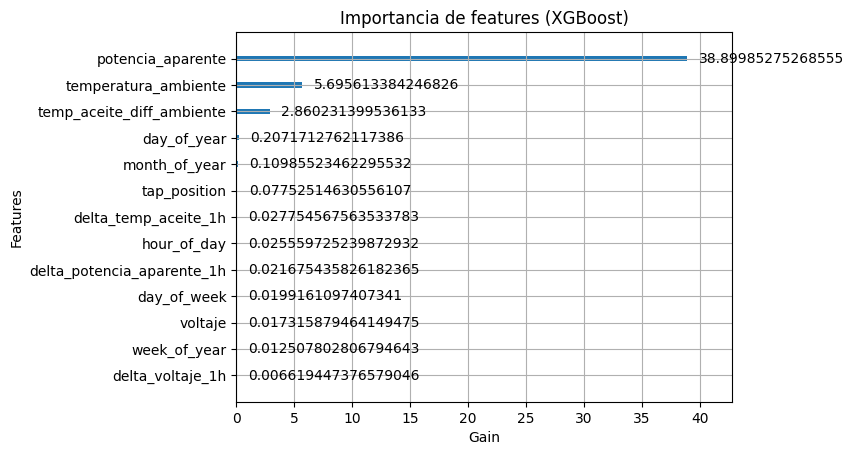

In [33]:
#Grafica de importancias de características
import matplotlib.pyplot as  plt
import xgboost as xgb
xgb.plot_importance(xgb_model, importance_type='gain', xlabel='Gain')
plt.title("Importancia de features (XGBoost)")
plt.show()


--- Visualización de Predicciones en el Conjunto de Validación ---


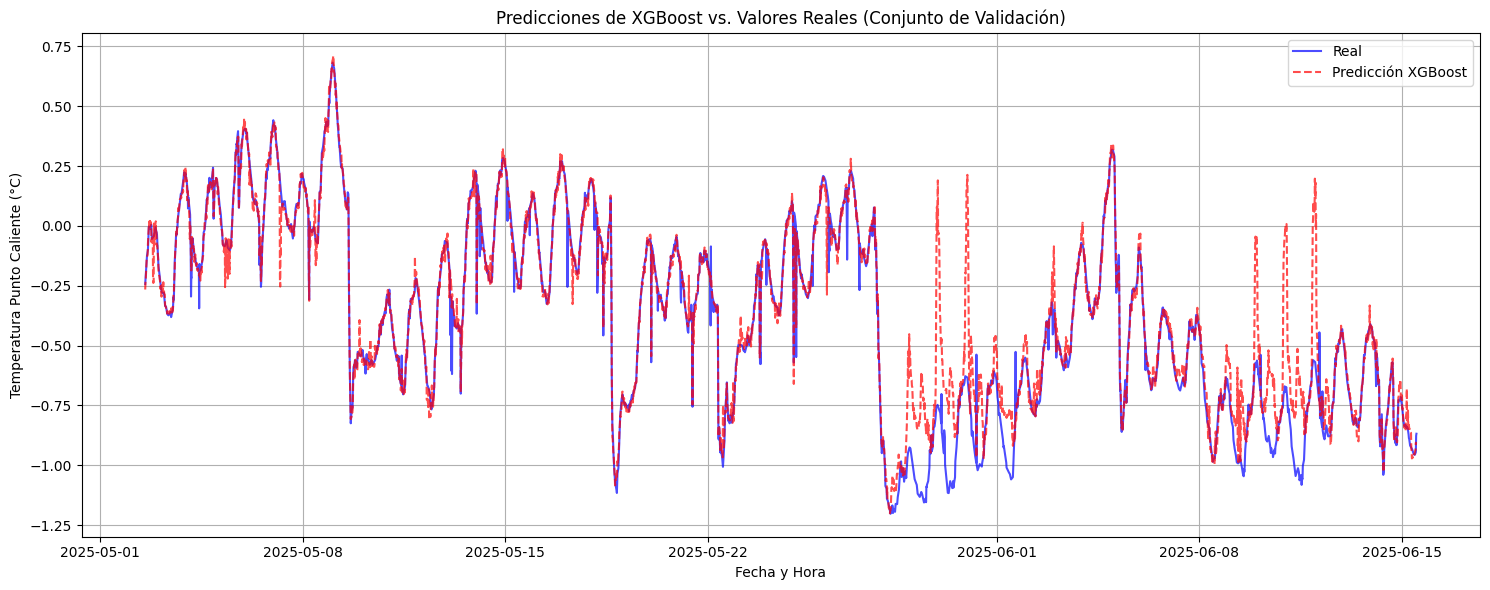

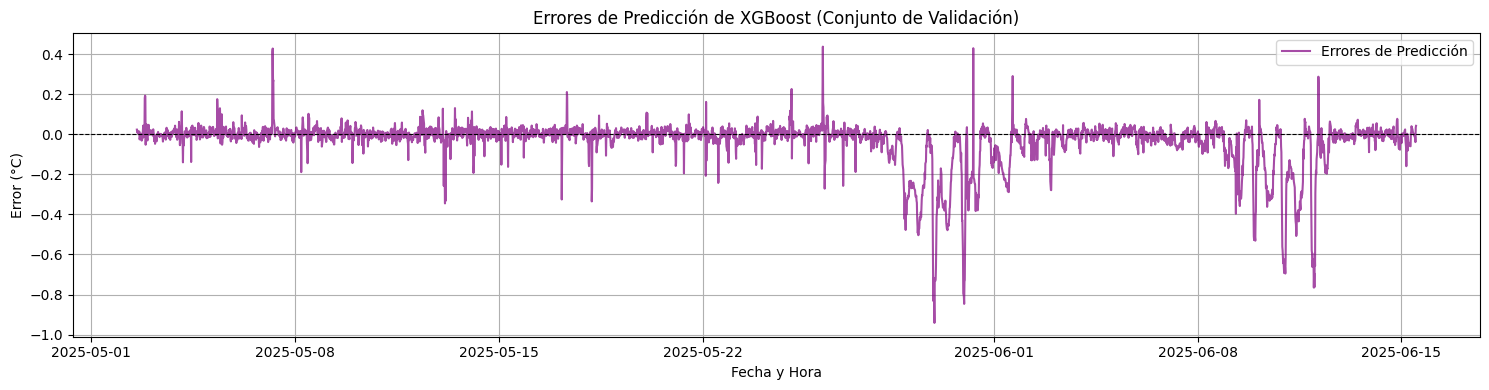

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Visualización de Predicciones en el Conjunto de Validación ---")

# Elegir el modelo con mejor rendimiento en validación para la visualización
# Por ejemplo, si XGBoost fue mejor, usaremos sus predicciones
# Asegúrate de que las predicciones ya se generaron en el paso anterior
# rf_val_predictions o xgb_val_predictions

# Si no tienes las predicciones guardadas, vuelve a generarlas:
rf_val_predictions = rf_model.predict(X_val)
xgb_val_predictions = xgb_model.predict(X_val)

# Elige el modelo a visualizar (ej. XGBoost si te dio mejores métricas)
model_to_visualize_predictions = xgb_val_predictions # Cambia a rf_val_predictions si Random Forest fue mejor
model_name = "XGBoost" # Cambia a "Random Forest" si Random Forest fue mejor

plt.figure(figsize=(15, 6))
plt.plot(Y_val.index, Y_val, label='Real', color='blue', alpha=0.7)
plt.plot(Y_val.index, model_to_visualize_predictions, label=f'Predicción {model_name}', color='red', linestyle='--', alpha=0.7)
plt.title(f'Predicciones de {model_name} vs. Valores Reales (Conjunto de Validación)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Temperatura Punto Caliente (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Opcional: Visualizar los errores de predicción
errors = Y_val - model_to_visualize_predictions
plt.figure(figsize=(15, 4))
plt.plot(Y_val.index, errors, label='Errores de Predicción', color='purple', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Errores de Predicción de {model_name} (Conjunto de Validación)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Error (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

INTERPRETACION 

Buen Ajuste General: A primera vista, la línea de predicción (roja discontinua) sigue muy de cerca la línea de valores reales (azul). Esto concuerda con el alto R2 que obtuviste. El modelo es capaz de capturar la tendencia principal y los cambios en la temperatura del punto caliente.

Captura de Patrones Diarios/Semanales: Se observa claramente un patrón cíclico (temperaturas más altas y bajas), que el modelo parece seguir adecuadamente, lo que sugiere que las características de tiempo (hora del día, día de la semana) y las características relacionadas con la carga están siendo bien utilizadas.

Momentos de Desajuste:

Hay periodos donde las predicciones se desvían más de los valores reales, especialmente durante cambios abruptos o picos. Por ejemplo, alrededor del 8-9 de mayo, 20-22 de mayo, y particularmente a principios de junio (alrededor del 1-5 de junio) y mediados de junio. En estos momentos, la línea roja se "separa" más de la azul, lo que contribuye a los errores (MAE y RMSE).

Los picos positivos y negativos más pronunciados a veces no son capturados con la misma exactitud, o el modelo los subestima/sobrastima ligeramente.

En Resumen: El modelo es muy bueno en general, pero el overfitting es el principal desafío a abordar.


--- Importancia de las Características ---

Top 10 Características más Importantes para XGBoost:
                       Feature  Importance
2            potencia_aparente    0.810724
1         temperatura_ambiente    0.118704
11   temp_aceite_diff_ambiente    0.059611
7                  day_of_year    0.004318
6                month_of_year    0.002290
3                 tap_position    0.001616
12        delta_temp_aceite_1h    0.000578
4                  hour_of_day    0.000533
13  delta_potencia_aparente_1h    0.000452
5                  day_of_week    0.000415


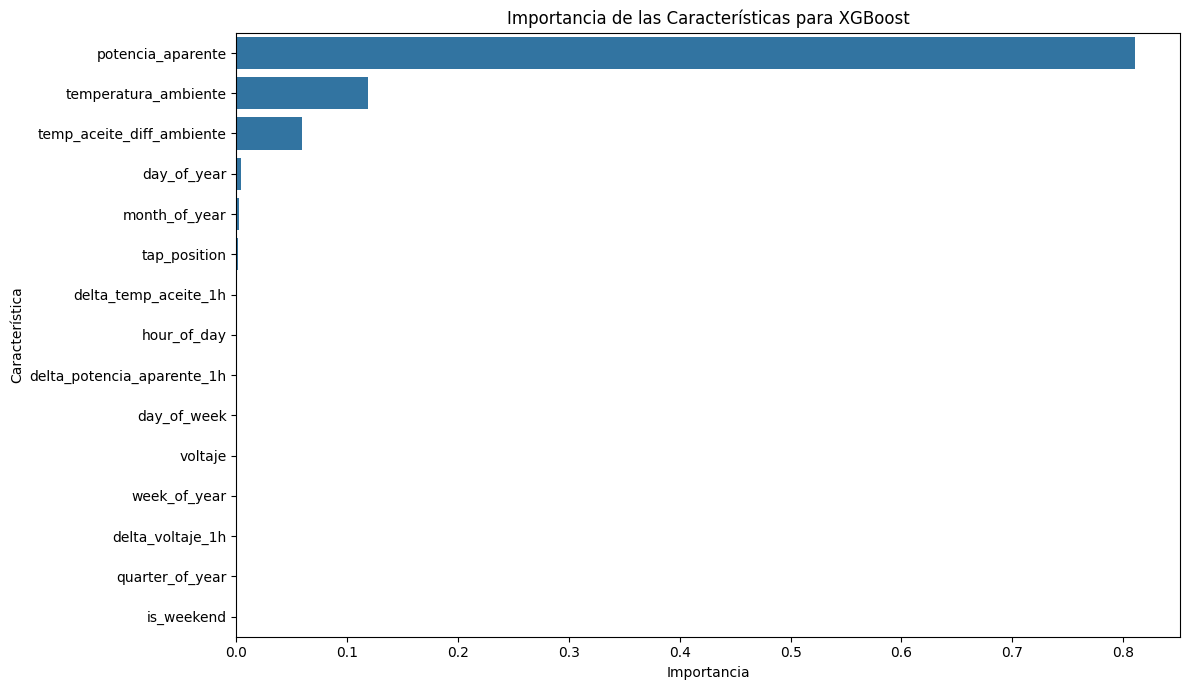

In [36]:
print("\n--- Importancia de las Características ---")

# Usar el modelo que mejor se desempeñó en la evaluación (ej. xgb_model)
# Si te decides por Random Forest, usa rf_model
model_for_importance = xgb_model # O rf_model
model_name_for_importance = "XGBoost" # O "Random Forest"

if hasattr(model_for_importance, 'feature_importances_'):
    feature_importances = model_for_importance.feature_importances_
    features = X_train.columns # Asegúrate de que esta lista de features es la misma que usaste para X_train

    # Crear un DataFrame para visualizar mejor
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f"\nTop 10 Características más Importantes para {model_name_for_importance}:")
    print(importance_df.head(10))

    # Visualizar la importancia de las características
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15)) # Muestra las 15 principales
    plt.title(f'Importancia de las Características para {model_name_for_importance}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()
else:
    print(f"El modelo {model_name_for_importance} no tiene el atributo 'feature_importances_'.")

Datasets Gold (Train, Val, Test) cargados correctamente.

--- Importancia de las Características (Random Forest) ---

Top 15 Características más Importantes para Random Forest:
                       Feature  Importance
2            potencia_aparente    0.721046
1         temperatura_ambiente    0.187558
11   temp_aceite_diff_ambiente    0.087993
7                  day_of_year    0.000685
12        delta_temp_aceite_1h    0.000488
8                 week_of_year    0.000474
13  delta_potencia_aparente_1h    0.000364
0                      voltaje    0.000341
14            delta_voltaje_1h    0.000265
3                 tap_position    0.000228
4                  hour_of_day    0.000209
5                  day_of_week    0.000173
10             quarter_of_year    0.000077
6                month_of_year    0.000072
9                   is_weekend    0.000026


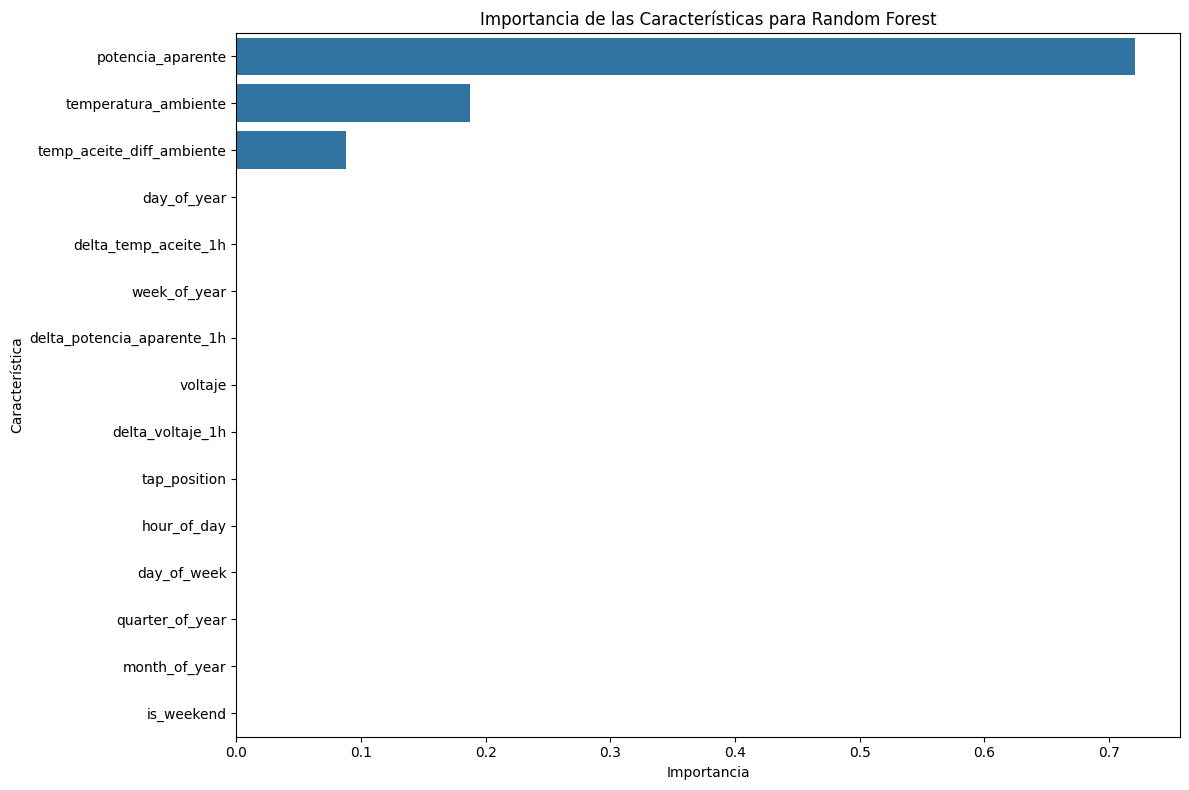

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Recargar los datos Gold (si no continuas del notebook anterior) ---
# Si continuas del mismo notebook, puedes saltar esta parte
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), "..", "..")) # Ajusta si tu notebook no está en etl/modelado
GOLD_DIR = os.path.join(BASE_DIR, "data", "gold")

try:
    df_train = pd.read_parquet(os.path.join(GOLD_DIR, "train_data.parquet"))
    df_val = pd.read_parquet(os.path.join(GOLD_DIR, "val_data.parquet"))
    df_test = pd.read_parquet(os.path.join(GOLD_DIR, "test_data.parquet"))
    print("Datasets Gold (Train, Val, Test) cargados correctamente.")
except FileNotFoundError:
    print(f"Error: No se encontraron los archivos Parquet en {GOLD_DIR}")
    print("Asegúrate de haber guardado los datasets de la capa Gold en el paso anterior.")
    exit()

# Definir la variable objetivo y las características
TARGET_VARIABLE = 'temperatura_punto_caliente'
features_to_exclude = [TARGET_VARIABLE, 'temp_punto_caliente_diff_aceite']
features = [col for col in df_train.columns if col not in features_to_exclude]

X_train = df_train[features]
Y_train = df_train[TARGET_VARIABLE]
X_val = df_val[features]
Y_val = df_val[TARGET_VARIABLE]

# Entrenar el modelo Random Forest (o recargarlo si ya lo hiciste)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)

print("\n--- Importancia de las Características (Random Forest) ---")

# Obtener la importancia de las características
feature_importances = rf_model.feature_importances_
features_names = X_train.columns

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(f"\nTop 15 Características más Importantes para Random Forest:")
print(importance_df.head(15))

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15)) # Muestra las 15 principales
plt.title('Importancia de las Características para Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.model_selection import GridSearchCV

print("\n--- Afinación de Hiperparámetros con GridSearchCV (Ejemplo con Random Forest) ---")

# Define el espacio de búsqueda de hiperparámetros
# ¡IMPORTANTE! Empieza con un rango pequeño para no tardar mucho
# Y adapta estos parámetros a tu modelo elegido (RF o XGBoost)
param_grid_rf = {
    'n_estimators': [50, 100, 200], # Número de árboles
    'max_depth': [None, 10, 20],   # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5]    # Mínimo de muestras para dividir un nodo
}

# Crea el objeto GridSearchCV
# cv=3 significa validación cruzada con 3 folds en el conjunto de entrenamiento
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                              param_grid=param_grid_rf,
                              scoring='neg_mean_absolute_error', # Para optimizar MAE (negativo porque GridSearchCV maximiza)
                              cv=3, verbose=1, n_jobs=-1)

# Ejecuta la búsqueda en el conjunto de entrenamiento (X_train, Y_train)
# OJO: Esto puede tomar tiempo dependiendo del tamaño de tus datos y del param_grid
# Si tienes problemas de rendimiento, usa RandomizedSearchCV o un rango más pequeño
print("Iniciando GridSearchCV para Random Forest...")
grid_search_rf.fit(X_train, Y_train)
print("GridSearchCV completado.")

# Muestra los mejores parámetros encontrados
print(f"\nMejores parámetros para Random Forest: {grid_search_rf.best_params_}")
print(f"Mejor MAE (negativo): {-grid_search_rf.best_score_:.3f}")

# Puedes obtener el mejor modelo entrenado
best_rf_model = grid_search_rf.best_estimator_

# Evalúa el mejor modelo en el conjunto de validación
print("\nEvaluando el mejor modelo Random Forest encontrado por GridSearchCV en VALIDACIÓN:")
evaluate_model(best_rf_model, X_val, Y_val, "Mejor Random Forest (Validación)")


--- Afinación de Hiperparámetros con GridSearchCV (Ejemplo con Random Forest) ---
Iniciando GridSearchCV para Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
GridSearchCV completado.

Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Mejor MAE (negativo): 0.040

Evaluando el mejor modelo Random Forest encontrado por GridSearchCV en VALIDACIÓN:

Resultados de Mejor Random Forest (Validación):
  MAE (Mean Absolute Error): 0.048
  RMSE (Root Mean Squared Error): 0.108
  R2 (Coefficient of Determination): 0.928


array([-0.2508317 , -0.20125041, -0.18531667, ..., -0.91700017,
       -0.91916057, -0.91756738], shape=(4219,))

In [ ]:
from sklearn.model_selection import GridSearchCV

print("\n--- Afinación de Hiperparámetros con GridSearchCV (Random Forest) ---")

# Definir el espacio de búsqueda de hiperparámetros
# Reduce el rango para que la ejecución no tome demasiado tiempo
# Estos son valores de ejemplo; deberías ajustarlos basados en tu experiencia y resultados iniciales
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None], # Profundidad máxima de los árboles (None significa sin límite)
    'min_samples_split': [2, 5, 10], # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],   # Número mínimo de muestras requeridas para ser un nodo hoja
    'max_features': [0.7, 0.9, 1.0] # Proporción de características a considerar para la mejor división
}

# Puedes definir una cuadrícula más pequeña para una prueba rápida
# param_grid_rf = {
#     'n_estimators': [100, 150],
#     'max_depth': [10, 20],
#     'min_samples_split': [5],
# }


# Crea el objeto GridSearchCV
# scoring='neg_mean_absolute_error' porque GridSearchCV intenta MAXIMIZAR la puntuación.
# n_jobs=-1 para usar todos los núcleos de tu CPU y acelerar el proceso.
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                              param_grid=param_grid_rf,
                              scoring='neg_mean_absolute_error', # Para optimizar MAE (MAE más bajo es mejor, así que se usa el negativo)
                              cv=3, # Número de folds para la validación cruzada. 3 es un buen inicio.
                              verbose=2, # Muestra más detalles durante la ejecución
                              n_jobs=-1)

print("Iniciando GridSearchCV para Random Forest. Esto puede tomar un tiempo considerable...")
# Ejecuta la búsqueda en el conjunto de entrenamiento
grid_search_rf.fit(X_train, Y_train)
print("GridSearchCV completado.")

# Obtener los mejores parámetros y la mejor puntuación
print(f"\nMejores parámetros encontrados para Random Forest: {grid_search_rf.best_params_}")
print(f"Mejor MAE (negativo, recuerde que es el valor 'maximizado'): {-grid_search_rf.best_score_:.3f}")

# Guardar el mejor modelo
best_rf_model = grid_search_rf.best_estimator_

# Evaluar el mejor modelo en el conjunto de VALIDACIÓN
print("\nEvaluando el MEJOR modelo Random Forest (afinación de hiperparámetros) en el conjunto de VALIDACIÓN:")
# Reutilizamos la función de evaluación
def evaluate_model(model, X, Y, name="Modelo"):
    predictions = model.predict(X)
    mae = mean_absolute_error(Y, predictions)
    rmse = np.sqrt(mean_squared_error(Y, predictions))
    r2 = r2_score(Y, predictions)
    print(f"\nResultados de {name}:")
    print(f"  MAE (Mean Absolute Error): {mae:.3f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.3f}")
    print(f"  R2 (Coefficient of Determination): {r2:.3f}")
    return predictions

tuned_rf_val_predictions = evaluate_model(best_rf_model, X_val, Y_val, "Random Forest Optimizado (Validación)")


--- Afinación de Hiperparámetros con GridSearchCV (Random Forest) ---
Iniciando GridSearchCV para Random Forest. Esto puede tomar un tiempo considerable...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
